<a href="https://colab.research.google.com/github/AlfAnalyst/study-projects-data-science-and-analysis/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D0%BF%D0%B0%D1%81%D1%81%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2_%D0%B0%D0%B2%D1%82%D0%BE%D0%B1%D1%83%D1%81%D0%B0_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задача.

Используя датасет "Пассажиры автобуса", создать нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Необходимо добиться точности работы модели выше 93% на проверочной выборке.

### Загрузка данных


In [ ]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image 

# Для отрисовки графиков
import matplotlib.pyplot as plt 

# Для генерации случайных чисел 
import random 

# Библиотека работы с массивами
import numpy as np 

# Для работы с файлами 
import os 

# импортируем модуль для загрузки данных
import gdown 

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam 

# модуль для отсчета времени
import time 

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import utils # Утилиты для to_categorical.


In [ ]:
# загрузка датасета, укажем путь к базе, база в виде .zip-архива 
gdown.download('bus.zip', None, quiet=True) 

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus  

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/' 

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH) 

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['entering', 'getting_off']


In [ ]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

entering : ['03110.jpg', '04448.jpg', '02193.jpg', '05599.jpg', '05092.jpg', '04055.jpg', '00429.jpg', '02389.jpg', '00780.jpg', '05188.jpg', '02330.jpg', '03957.jpg', '02379.jpg', '02103.jpg', '04266.jpg', '03094.jpg', '04748.jpg', '03927.jpg', '02540.jpg', '04330.jpg', '05096.jpg', '04304.jpg', '04822.jpg', '02544.jpg', '05185.jpg', '00254.jpg', '03502.jpg', '04643.jpg', '02383.jpg', '03607.jpg', '06290.jpg', '01722.jpg', '00982.jpg', '03049.jpg', '01470.jpg', '02087.jpg', '04221.jpg', '05162.jpg', '04496.jpg', '00157.jpg', '02824.jpg', '05621.jpg', '00025.jpg', '05429.jpg', '02676.jpg', '00469.jpg', '06118.jpg', '04827.jpg', '02339.jpg', '04331.jpg', '03991.jpg', '00053.jpg', '03471.jpg', '00621.jpg', '04811.jpg', '04154.jpg', '00246.jpg', '03870.jpg', '03805.jpg', '04285.jpg', '03159.jpg', '00465.jpg', '05472.jpg', '05680.jpg', '05840.jpg', '05025.jpg', '06018.jpg', '02625.jpg', '04406.jpg', '06102.jpg', '02024.jpg', '00447.jpg', '06009.jpg', '00769.jpg', '05481.jpg', '00834.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

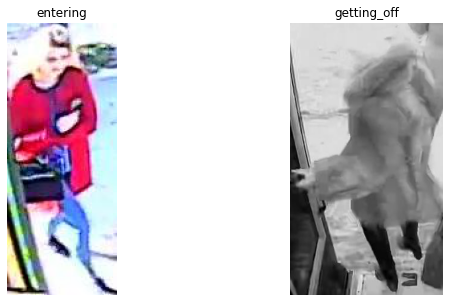

In [ ]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path)) 
    
    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))  
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [ ]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса entering составляет 6485 фото
Размер класса getting_off составляет 2596 фото

Общий размер базы для обучения: 9081


In [ ]:
print(f'Список содержит путь к файлу: {data_files[6483:6487]}')
print(f'Список содержит метки классов: {data_labels[6483:6487]}')

Список содержит путь к файлу: ['/content/bus/entering/03739.jpg', '/content/bus/entering/02050.jpg', '/content/bus/getting_off/02193.jpg', '/content/bus/getting_off/00429.jpg']
Список содержит метки классов: [0, 0, 1, 1]


In [ ]:
img1 = Image.open(data_files[0]) # Загружаем первое изображение.
img1_np = np.array(img1) # Переводим первое изображение в массив.
print(f'Размерность первого изображения: {img1_np.shape}')

Размерность первого изображения: (185, 155, 3)


In [ ]:
n = np.random.randint(len(data_files))
imgn = Image.open(data_files[n]) # Загружаем последнее изображение.
imgn_np = np.array(imgn) # Переводим ппоследнее изображение в массив.
print(f'Размерность случайного изображения: {imgn_np.shape}')

Размерность случайного изображения: (95, 120, 3)


In [ ]:
img9080 = Image.open(data_files[9080]) # Загружаем последнее изображение.
img9080_np = np.array(img9080) # Переводим ппоследнее изображение в массив.
print(f'Размерность последнего изображения: {img9080_np.shape}')

Размерность последнего изображения: (156, 180, 3)


In [ ]:
# Задаем размеры изображений.
img_height = 150 # Высота изображения.
img_widht = 150 # Ширина изображения.

In [ ]:
data_images = [] # В списке будут храниться изображения.

for file_name in data_files:
  img = Image.open(file_name).resize((img_widht, img_height)) # Открываем и меняем размеры изображений.
  img_np = np.array(img) # Переводим изображение в массив.
  data_images.append(img_np) # Добавляем изображение в список.

X = np.array(data_images) # Переводим список изображений в массив.
Y = np.array(data_labels) # Переводим список меток классов в массив.

print(f'Размерность массива данных: {X.shape}')
print(f'Размерность массива меток классов: {Y.shape}')

Размерность массива данных: (9081, 150, 150, 3)
Размерность массива меток классов: (9081,)


In [ ]:
X[2] # Посмотрим на пример массива изображений.

In [ ]:
X = X.astype('float32')
X_new = X / 255 # Нормируем изображения.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.1) # Выделяем тестовую выборку.

In [ ]:
# Преобразовываем ответы в формат one_hot_encoding.
y_train = utils.to_categorical(y_train, 2)
y_test = utils.to_categorical(y_test, 2)

In [ ]:
print(f'Размерность обучающей выборки: {x_train.shape}')
print(f'Размерность тестовой выборки: {x_test.shape}')
print(f'Размерность меток обучающей выборки: {y_train.shape}')
print(f'Размерность меток тестовой выборки: {y_test.shape}')

Размерность обучающей выборки: (8172, 150, 150, 3)
Размерность тестовой выборки: (909, 150, 150, 3)
Размерность меток обучающей выборки: (8172, 2)
Размерность меток тестовой выборки: (909, 2)


In [ ]:
model1 = Sequential() # Создаем нейронную сеть.

model1.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3))) # Сверточный слой.
model1.add(BatchNormalization()) # Слой нормализации.
model1.add(Conv2D(16, (3, 3), padding='same', activation='relu')) # Сверточный слой.

model1.add(MaxPooling2D(pool_size=(2, 2))) # Слой подвыборки.

model1.add(Dropout(0.2)) # Слой регуляризации.

model1.add(Conv2D(32, (3, 3), padding='same', activation='relu')) # Сверточный слой.
model1.add(BatchNormalization()) # Слой нормализации.
model1.add(Conv2D(32, (3, 3), padding='same', activation='relu')) # Сверточный слой.

model1.add(MaxPooling2D(pool_size=(2, 2))) # Слой подвыборки.

model1.add(Dropout(0.2)) # Слой регуляризации.

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu')) # Сверточный слой.
model1.add(BatchNormalization()) # Слой нормализации.
model1.add(Conv2D(64, (3, 3), padding='same', activation='relu')) # Сверточный слой.

model1.add(MaxPooling2D(pool_size=(2, 2))) # Слой подвыборки.

model1.add(Dropout(0.2)) # Слой регуляризации.

model1.add(Flatten())  
model1.add(Dense(300, activation='relu')) # Полносвязный слой.
model1.add(Dropout(0.2)) # Слой регуляризации.
model1.add(Dense(2, activation='softmax')) # Выходной полносвязный слой.

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy']) # Компилируем модель.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
batch_size1 = 60
epochs1 = 25

In [ ]:
history1 = model1.fit(x_train, y_train, batch_size=batch_size1, epochs=epochs1, validation_split=0.1, verbose=1)

Epoch 1/25
123/123 [==============================] - 452s 4s/step - loss: 1.4193 - accuracy: 0.7059 - val_loss: 0.6269 - val_accuracy: 0.7298
Epoch 2/25
123/123 [==============================] - 443s 4s/step - loss: 0.5031 - accuracy: 0.7555 - val_loss: 0.4932 - val_accuracy: 0.7971
Epoch 3/25
123/123 [==============================] - 446s 4s/step - loss: 0.3786 - accuracy: 0.8189 - val_loss: 0.5174 - val_accuracy: 0.8423
Epoch 4/25
123/123 [==============================] - 448s 4s/step - loss: 0.2918 - accuracy: 0.8589 - val_loss: 1.1248 - val_accuracy: 0.7848
Epoch 5/25
123/123 [==============================] - 447s 4s/step - loss: 0.2415 - accuracy: 0.8859 - val_loss: 0.2547 - val_accuracy: 0.8875
Epoch 6/25
123/123 [==============================] - 446s 4s/step - loss: 0.1927 - accuracy: 0.9171 - val_loss: 0.2093 - val_accuracy: 0.8998
Epoch 7/25
123/123 [==============================] - 448s 4s/step - loss: 0.1527 - accuracy: 0.9313 - val_loss: 0.1445 - val_accuracy: 0.9438

In [ ]:
val_acc1 =round(history1.history['val_accuracy'][-2], 4) * 100
print(f'Доля верных ответов на предпоследней эпохе обучения на проверочной выборке: {val_acc1}')

Доля верных ответов на предпоследней эпохе обучения на проверочной выборке: 98.66


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model1.save_weights('/content/drive/MyDrive/models/mod_pass17')

Модель следует дообучить с уменьшением learning rate, но уже сейчас модель показывает хорошую точность и есть потенциал к дообучению.